In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

Code to generate Table 3 for the paper (see Section 3.2 "Experiments with Real Data")

In [2]:
# File paths
merged_results_file = "../results/merged_results.csv"
output_file = "../results/table3.csv"

# Read CSVs
df_merged = pd.read_csv(merged_results_file)

In [3]:
# Compute median and mean for numeric columns
median_row = [ "Median" ] + df_merged.iloc[:, 1:].median(numeric_only=True).tolist()
mean_row   = [ "Mean" ] + df_merged.iloc[:, 1:].mean(numeric_only=True).tolist()

# Append stats rows
summary_df = pd.DataFrame([median_row, mean_row], columns=df_merged.columns)
final_df = pd.concat([df_merged, summary_df], ignore_index=True)

# Save to CSV
final_df.to_csv(output_file, index=False)

print(f"✅ Final CSV saved to: {output_file}")

final_df = final_df.round(9)
final_df.round(4)

✅ Final CSV saved to: ../results/table3.csv


,Datasets,ClustRecNet (CH),ClustRecNet (Sil),Baseline CNN,AutoCluster (CH),AutoCluster (SIL),AutoCluster (DB),AML4C,ML2DAC
0,BreastTissue,0.2682,0.2682,0.2682,0.2398,0.2398,0.2398,0.2099,0.2099
1,Ecoli,0.5011,0.5011,0.5011,0.5011,0.5011,0.5011,0.1535,0.3863
2,Glass,0.2453,0.2453,0.2453,0.1399,0.1399,0.1399,0.0994,0.1472
3,Haberman,0.1040,0.1040,0.0274,0.1556,0.0621,0.0621,0.0323,0.0323
4,Iris,0.5681,0.5681,0.5681,0.5584,0.5438,0.5438,0.5681,0.5681
5,Parkinsons,0.0514,0.1218,0.0514,0.0000,0.0000,0.0000,0.0473,0.0473
6,Transfusion,0.0193,0.0193,0.0131,0.0174,0.0304,0.0095,0.0196,0.0344
7,Vehicle,0.1097,0.0869,0.0878,0.0125,0.0119,0.0088,0.1380,0.1333
8,VertebralColumn,0.3669,0.3669,0.1361,0.3669,0.0967,0.3369,0.1211,0.2885
9,WineQualityRed,0.0611,-0.0029,0.0157,0.0000,0.0000,0.0000,0.0505,0.0505


Code to generate Figure 4 for the paper (see Section 3.2 "Experiments with Real Data")

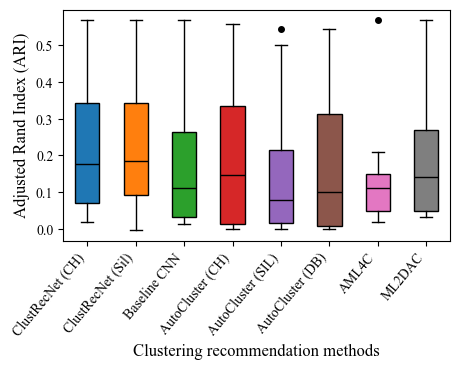

'../results/fig4_boxplot_comparison.pdf'

In [9]:
# Set global font and save config (Times, Type 1 compatible, CMYK-safe)
plt.rcParams.update({
    "text.usetex": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

# Exclude first column (dataset names) and last 2 rows (median, mean)
ari_data = final_df.iloc[:-2, 1:]
readable_labels = list(ari_data.columns)

# Define custom CMYK-safe and color-blind-friendly colors for each box
box_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
][:len(readable_labels)]  # Ensure match with number of boxes

# Plot
fig, ax = plt.subplots(figsize=(5, 3))

# Box plot with consistent color and whiskers
box = ax.boxplot(
    ari_data.values,
    patch_artist=True,
    boxprops=dict(color='black'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4, linestyle='none'),
    medianprops=dict(color='black')
)

for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# Set X-axis
ax.set_xticks(range(1, len(readable_labels) + 1))
ax.set_xticklabels(readable_labels, rotation=50, ha='right')
ax.set_ylabel("Adjusted Rand Index (ARI)")
ax.set_xlabel("Clustering recommendation methods")

# Save final figure
output_path = "../results/fig4_boxplot_comparison.pdf"
fig.savefig(output_path, dpi=600, bbox_inches='tight', backend='cairo')
plt.show()

output_path

In [10]:
# Extract only the numeric ARI values (excluding summary rows)
ari_data = final_df.iloc[:-2, 1:]  # Drop 'Dataset' and last two rows

# Define main model and skip ClustRecNet (Sil)
main_col = "ClustRecNet (CH)"
comparison_cols = [col for col in ari_data.columns if col != main_col and col != "ClustRecNet (Sil)"]

results = []

for comp_col in comparison_cols:
    x = ari_data[main_col].astype(float).values
    y = ari_data[comp_col].astype(float).values
    diffs = x - y

    try:
        stat, p = wilcoxon(x, y, zero_method='wilcox', alternative="greater")

        # Determine which model is better
        if (diffs > 0).sum() > (diffs < 0).sum():
            better = "Yes"
        elif (diffs < 0).sum() > (diffs > 0).sum():
            better = "No"
        else:
            better = "Equal"

        results.append({
            "Model": main_col,
            "Comparison": f"{main_col} vs {comp_col}",
            "Wilcoxon Statistic": stat,
            "p-value": p,
            "Proposed Better?": better
        })
    except ValueError:
        results.append({
            "Model": main_col,
            "Comparison": f"{main_col} vs {comp_col}",
            "Wilcoxon Statistic": None,
            "p-value": "All differences zero",
            "Proposed Better?": "Equal"
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Check statistical significance
def is_significant(p):
    try:
        return "Yes" if float(p) < 0.05 else "No"
    except:
        return "N/A"

results_df["Statistically Significant?"] = results_df["p-value"].apply(is_significant)

# Save to CSV
results_df.to_csv("../results/table4.csv", index=False)
print("✅ Wilcoxon results saved to: ../results/table4.csv")

results_df.round(4)

✅ Wilcoxon results saved to: ../results/table4.csv


,Model,Comparison,Wilcoxon Statistic,p-value,Proposed Better?,Statistically Significant?
0,ClustRecNet (CH),ClustRecNet (CH) vs Baseline CNN,15.0,0.0312,Yes,Yes
1,ClustRecNet (CH),ClustRecNet (CH) vs AutoCluster (CH),31.0,0.0391,Yes,Yes
2,ClustRecNet (CH),ClustRecNet (CH) vs AutoCluster (SIL),44.0,0.0039,Yes,Yes
3,ClustRecNet (CH),ClustRecNet (CH) vs AutoCluster (DB),45.0,0.0020,Yes,Yes
4,ClustRecNet (CH),ClustRecNet (CH) vs AML4C,40.0,0.0195,Yes,Yes
5,ClustRecNet (CH),ClustRecNet (CH) vs ML2DAC,38.0,0.0371,Yes,Yes
